# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [11]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [22]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'data/templates/bjet_binned_test/'
selections = [
              'emu', 
              'ee', 'mumu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

p_labels = ['B_e', 'B_mu', 'B_tau', 'B_h', 'L', 'sigma_tt', 'sigma_z', 'sigma_w', 'k_fake', 'eff_e', 'eff_mu', 'eff_tau', 'pileup', 'escale_e', 'escale_mu', 'escale_tau', 'jes', 'jer', 'btag', 'mistag']

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets, bins=[1, 2])

In [24]:
# generate Asimov dataset
toy_data = dict()
for b in fit_data._bins:
    toy_data[b] = dict()
    for selection in selections:
        # signal component
        templates = fit_data.get_selection_data(selection)
        signal_template = templates[b]['signal']
        signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)[0]

        toy_data[b][selection] = signal
        # background component
        for bg in ['zjets', 'wjets', 'fakes']:
            if bg == 'fakes' and selection not in ['mu4j', 'mutau']:
                continue

            bg_template = templates[b][bg][0]
            toy_data[b][selection] += bg_template

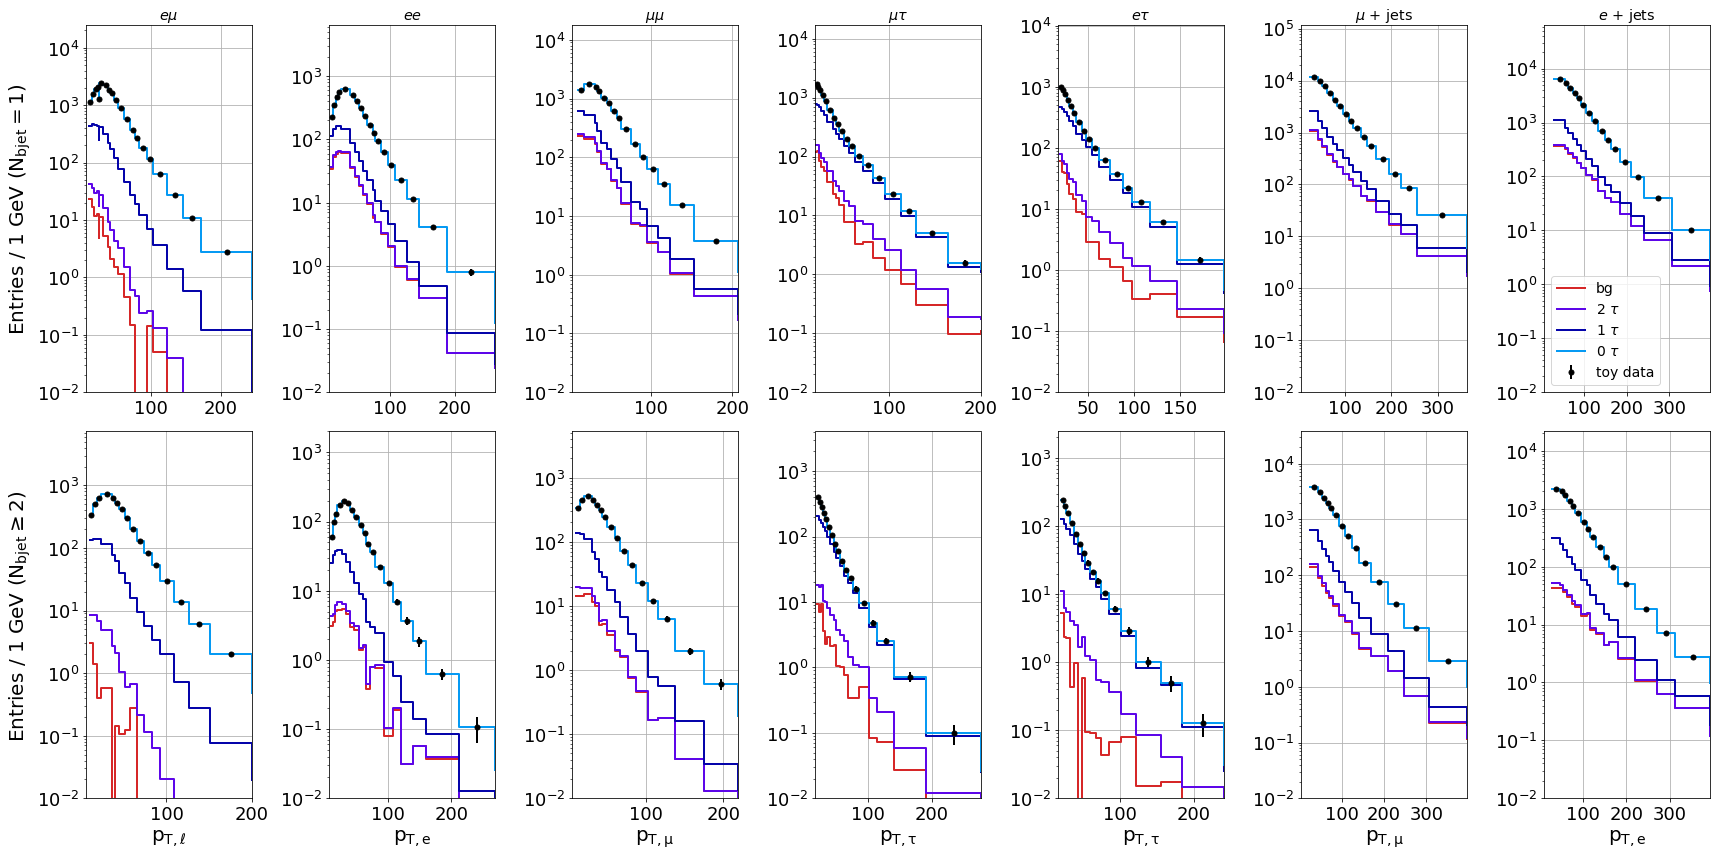

In [25]:
# visualize toy data
fig, axes = plt.subplots(2, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    s_data = fit_data.get_selection_data(selection)
#
    for j, b in enumerate(fit_data._bins):
        bins = s_data[b]['bins']
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x = bins + dx/2            

        ax = axes[j][i]
        data = toy_data[b][selection]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # validation plot
        br = 0.108
        signal = s_data[b]['signal']
        bg = s_data[b]['wjets'][0] + s_data[b]['zjets'][0]
        if selection in ['mu4j', 'mutau']:
            bg += s_data[b]['fakes'][0]
            
        h_notau   = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_twotau']) + bg
        h_onetau  = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal, mask=fit_data._decay_map['sig_onetau']) + h_notau
        h_nominal = fh.signal_mixture_model([br, br, br, 1. - 3*br], br_tau, signal) + bg
        
        ax.plot(bins, bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_notau[0]/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau[0]/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal[0]/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
        if j == 0:
            ax.set_title(plot_labels[selection][1])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif j == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [15]:
# nominal case
cost_type = 'poisson'
p_init = list(fit_data.get_params_init()) + 8*[1., ] + 8*[1., ] # niceify this: nuisance parameters are initialized to 1
p_init = np.array(p_init)
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

In [16]:
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(100*stderr/p_init, index=p_labels, columns=['stderr'])
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
pct_err

,stderr
B_e,0.808
B_mu,0.698
B_tau,2.061
B_h,0.364
L,1.746
sigma_tt,2.042
sigma_z,4.828
sigma_w,6.745
k_fake,9.195
eff_e,0.779


In [17]:
df_corr.to_latex('data/cov_table_full.tex')
df_corr

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau,pileup,escale_e,escale_mu,escale_tau,jes,jer,btag,mistag
B_e,1.000,0.080,-0.023,-0.358,-0.100,-0.201,0.110,0.214,0.134,-0.611,0.195,0.219,0.132,-0.105,0.010,-0.004,-0.319,-0.066,-0.127,-0.059
B_mu,0.080,1.000,-0.075,-0.267,-0.079,-0.162,0.118,0.190,-0.094,0.144,-0.566,0.215,-0.011,0.200,-0.007,0.031,-0.296,-0.031,-0.046,-0.057
B_tau,-0.023,-0.075,1.000,-0.874,-0.065,-0.109,-0.331,0.106,-0.213,-0.091,-0.055,-0.732,-0.281,-0.327,0.325,-0.283,-0.351,-0.031,-0.063,-0.074
B_h,-0.358,-0.267,-0.874,1.000,0.118,0.220,0.225,-0.230,0.174,0.255,0.154,0.519,0.211,0.272,-0.295,0.248,0.522,0.061,0.116,0.105
L,-0.100,-0.079,-0.065,0.118,1.000,-0.601,-0.299,-0.356,0.010,-0.139,-0.160,-0.117,0.009,0.047,-0.019,0.066,0.265,0.020,0.103,0.020
sigma_tt,-0.201,-0.162,-0.109,0.220,-0.601,1.000,0.296,-0.086,0.013,-0.256,-0.300,-0.230,0.005,0.076,-0.032,0.105,0.495,0.031,0.205,0.048
sigma_z,0.110,0.118,-0.331,0.225,-0.299,0.296,1.000,0.034,0.307,-0.139,-0.182,0.250,0.091,-0.094,-0.095,0.151,0.059,0.019,-0.094,0.075
sigma_w,0.214,0.190,0.106,-0.230,-0.356,-0.086,0.034,1.000,-0.106,0.160,0.260,0.102,0.103,0.156,0.017,0.090,-0.254,0.052,-0.200,-0.188
k_fake,0.134,-0.094,-0.213,0.174,0.010,0.013,0.307,-0.106,1.000,0.009,-0.006,0.189,0.256,-0.464,-0.086,-0.073,0.211,0.023,-0.127,0.018
eff_e,-0.611,0.144,-0.091,0.255,-0.139,-0.256,-0.139,0.160,0.009,1.000,0.309,0.317,-0.003,0.038,-0.056,-0.112,-0.253,-0.024,-0.126,-0.060


In [18]:
# n-1 uncertainties
from tqdm import tqdm_notebook, trange

def reduced_objective(p, i, j=None):
    if j == None or j < i:
        j = i
        
    p = np.concatenate([p[:i], (j - i + 1)*[1,], p[j:]])
    return fit_data.objective(p, data=toy_data, cost_type=cost_type)

# stat only
fobj = partial(reduced_objective, i=4, j=len(p_init))
stderr_stat = np.concatenate([fh.calculate_covariance(fobj, p_init[:4])[0], p_init[4:].size*[0.,]])

errs = [stderr_stat]
p_init = p_init
for i in tqdm_notebook(range(4, len(p_init))):
    fobj = partial(reduced_objective, i=i)
    stderr, cov = fh.calculate_covariance(fobj, p_init[:-1])
    
    stderr = np.concatenate([stderr[:i], [0], stderr[i:]])
    errs.append(stderr)
    
# full systematics
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr_nominal = fh.calculate_covariance(fobj, p_init)[0]
errs.append(stderr_nominal)

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

In [19]:
errs = pd.DataFrame(errs, columns=p_labels, index=['stat only'] + p_labels[4:] + ['full'])
errs.divide(p_init/100, axis=1)

,B_e,B_mu,B_tau,B_h,L,sigma_tt,sigma_z,sigma_w,k_fake,eff_e,eff_mu,eff_tau,pileup,escale_e,escale_mu,escale_tau,jes,jer,btag,mistag
stat only,0.137,0.109,0.609,0.092,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
L,0.804,0.696,2.057,0.361,0.000,1.632,4.607,6.304,9.195,0.772,0.731,1.105,9.168,8.828,15.738,50.139,25.248,76.859,5.019,95.667
sigma_tt,0.792,0.689,2.048,0.355,1.395,0.000,4.612,6.720,9.195,0.753,0.707,1.083,9.169,8.812,15.733,49.971,22.759,76.837,4.938,95.578
sigma_z,0.804,0.693,1.945,0.354,1.666,1.950,0.000,6.741,8.751,0.772,0.728,1.078,9.130,8.798,15.670,49.675,26.140,76.861,5.023,95.414
sigma_w,0.790,0.686,2.049,0.354,1.632,2.034,4.825,0.000,9.144,0.769,0.715,1.107,9.120,8.729,15.739,50.046,25.327,76.769,4.943,93.977
k_fake,0.801,0.695,2.013,0.358,1.746,2.041,4.595,6.707,0.000,0.779,0.741,1.093,8.864,7.831,15.683,50.116,25.596,76.854,5.005,95.671
eff_e,0.640,0.691,2.052,0.352,1.729,1.974,4.781,6.658,9.195,0.000,0.704,1.056,9.169,8.831,15.716,49.932,25.336,76.853,5.005,95.516
eff_mu,0.793,0.576,2.058,0.359,1.723,1.947,4.747,6.512,9.195,0.741,0.000,1.053,9.163,8.778,15.739,50.046,24.273,76.743,5.017,95.381
eff_tau,0.789,0.682,1.403,0.311,1.734,1.987,4.674,6.709,9.029,0.739,0.701,0.000,8.924,8.706,15.519,49.999,25.693,76.734,5.004,95.681
pileup,0.801,0.698,1.978,0.356,1.746,2.042,4.808,6.709,8.890,0.779,0.740,1.083,0.000,8.834,15.534,45.687,24.958,76.875,4.911,95.686


### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$


In [20]:
beta_vars = errs.iloc[:,:4]**2
var_stat = beta_vars.iloc[0]
var_nom  = beta_vars.iloc[-1]

for i in trange(1, beta_vars.shape[0] - 1):
    beta_vars.iloc[i] = var_nom - beta_vars.iloc[i]
    
beta_errs = np.sqrt(beta_vars)
100*beta_errs.divide(p_init[:4], axis=1)

100%|██████████| 16/16 [00:00<00:00, 2961.82it/s]


,B_e,B_mu,B_tau,B_h
stat only,0.137,0.109,0.609,0.092
L,0.081,0.056,0.133,0.043
sigma_tt,0.162,0.113,0.225,0.080
sigma_z,0.089,0.082,0.683,0.082
sigma_w,0.173,0.132,0.219,0.084
k_fake,0.109,0.065,0.439,0.063
eff_e,0.494,0.101,0.188,0.093
eff_mu,0.157,0.396,0.113,0.056
eff_tau,0.177,0.150,1.509,0.189
pileup,0.107,0.008,0.580,0.077
